In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools

from utilities import *
from analysis import *

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 376 features.
UK BioBank Data Loaded.
Size: 502536 rows x 376 columns
Elapsed time: 62.3357 seconds


Mapping Medical Codes:   0%|          | 0/361 [00:00<?, ? feature/s]

In [5]:
biobank_data

,eid,sex,birth_year,birth_month,assessment_date,n_cancers,n_cancers_1.0,n_cancers_2.0,n_non_cancer_illnesses,n_non_cancer_illnesses_1.0,...,operative_procedures_OPCS4_secondary,A1,A2,B1,B2,C1,C2,zygosity,effective_zygosity,grantham_divergence
0,1000013,Male,1962.0,April,2008-02-19,0.0,NaN,NaN,2.0,NaN,...,NaN,A*02:01,A*02:01,B*44:02,B*57:01,C*05:01,C*06:02,1.0,1.0,31.481250
1,1000024,Female,1941.0,January,2010-06-04,1.0,NaN,NaN,0.0,NaN,...,Z50.4 Skin of leg NEC,A*01:01,A*01:01,B*07:02,B*08:01,C*07:01,C*07:02,1.0,1.0,32.060417
2,1000036,Female,1955.0,August,2009-02-11,1.0,NaN,NaN,0.0,NaN,...,T87.3 Excision or biopsy of axillary lymph node,A*02:01,A*34:02,B*14:01,B*44:02,C*05:01,C*08:02,0.0,0.0,30.402083
3,1000048,Male,1941.0,April,2009-10-26,0.0,NaN,NaN,2.0,NaN,...,NaN,A*02:01,A*68:01,B*07:02,B*51:01,C*01:02,C*07:02,0.0,0.0,34.847917
4,1000055,Female,1947.0,October,2008-03-06,0.0,NaN,NaN,4.0,NaN,...,K40.1 Saphenous vein graft replacement of one ...,A*01:01,A*03:01,B*13:02,B*57:01,C*06:02,C*06:02,1.0,1.0,33.218750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502531,6025324,Female,1967.0,April,2009-07-04,0.0,NaN,0.0,1.0,NaN,...,H22.9 Unspecified diagnostic endoscopic examin...,A*01:01,A*01:01,B*08:01,B*57:01,C*06:02,C*07:01,1.0,1.0,34.416667
502532,6025336,Female,1964.0,August,2008-05-16,1.0,NaN,NaN,5.0,NaN,...,Q22.1 Bilateral salpingoophorectomy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502533,6025348,Male,1945.0,October,2010-02-18,0.0,NaN,NaN,0.0,NaN,...,Y75.2 Laparoscopic approach to abdominal cavit...,A*24:02,A*24:02,B*15:01,B*51:01,C*02:02,C*03:03,1.0,1.0,33.577083
502534,6025355,Female,1947.0,November,2008-06-28,0.0,NaN,NaN,4.0,NaN,...,Y84.8 Other specified other anaesthetic,A*02:01,A*03:01,B*15:01,B*44:02,C*03:04,C*05:01,0.0,0.0,28.656250


# Constants

In [6]:
female_specific_cancers = ["breast cancer", "female genital tract cancer", "cervical cancer",
                           "cin/pre-cancer cells cervix", "fallopian tube cancer", "ovarian cancer",
                           "uterine/endometrial cancer", "vaginal cancer", "vulval cancer" ]

male_specific_cancers = ["male genital tract cancer", "penis cancer", "prostate cancer", "testicular cancer"]
sex_specific_cancers = female_specific_cancers + male_specific_cancers

# Viral Codes

In [7]:
mononucleosis_code = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
hiv_code = 'hiv/aids'
herpes_simplex_code = "herpes simplex"
hepatitis_code = "infective/viral hepatitis"

data_tools.biobank_search(med_code_mapping, biobank_data, ('merkel'))

,coding,meaning,code_format,name,count
115,8247,Merkel cell carcinoma,38,cancer_tumor_histology,8


In [8]:
biobank_data.query("cancer_tumor_histology == 'Merkel cell carcinoma'")

,eid,sex,birth_year,birth_month,assessment_date,n_cancers,n_cancers_1.0,n_cancers_2.0,n_non_cancer_illnesses,n_non_cancer_illnesses_1.0,...,operative_procedures_OPCS4_secondary,A1,A2,B1,B2,C1,C2,zygosity,effective_zygosity,grantham_divergence
85665,1856669,Female,1943.0,February,2009-03-02,1.0,NaN,NaN,2.0,NaN,...,W58.1 Primary resurfacing arthroplasty of joint,A*01:01,A*11:01,B*15:01,B*44:02,C*03:03,C*07:04,0.0,0.0,34.545833
129077,2290789,Male,1943.0,April,2010-03-15,1.0,NaN,NaN,4.0,NaN,...,S27.5 Local flap of skin to head or neck NEC,A*02:01,A*68:01,B*44:02,B*44:02,C*04:01,C*05:01,1.0,1.0,32.266667
180569,2805701,Male,1938.0,December,2008-03-19,0.0,NaN,NaN,1.0,NaN,...,G45.9 Unspecified diagnostic fibreoptic endosc...,A*02:01,A*02:01,B*07:02,B*13:02,C*06:02,C*07:02,1.0,1.0,31.960417
215287,3152889,Male,1950.0,April,2010-05-07,0.0,1.0,1.0,2.0,5.0,...,A61.1 Excision of lesion of peripheral nerve,A*02:01,A*02:01,B*15:01,B*44:02,C*03:04,C*05:01,1.0,1.0,26.593750
276317,3763186,Male,1943.0,April,2008-06-11,0.0,NaN,NaN,3.0,NaN,...,L68.8 Other specified repair of other artery,A*24:02,A*30:01,B*27:05,B*57:01,C*02:02,C*06:02,0.0,0.0,33.202083
289960,3899619,Female,1947.0,October,2008-09-16,0.0,NaN,NaN,4.0,NaN,...,S27.5 Local flap of skin to head or neck NEC,A*11:01,A*25:01,B*35:01,B*44:02,C*04:01,C*05:01,0.0,0.0,32.658333
322325,4223269,Female,1942.0,November,2008-03-29,1.0,NaN,NaN,8.0,NaN,...,C71.2 Phacoemulsification of lens,A*02:01,A*02:01,B*40:01,B*40:01,C*03:04,C*03:04,3.0,3.0,21.525000
356684,4566852,Male,1940.0,May,2010-02-09,2.0,NaN,NaN,2.0,NaN,...,F44.1 Total excision of parotid gland,A*02:01,A*03:01,B*07:02,B*18:01,C*07:01,C*07:02,0.0,0.0,30.881250


 # Exploring ICD 10 Cancer Types

In [9]:
ICD10_data = biobank_data.loc[~biobank_data["cancer_type_ICD10"].isna()].copy(deep=True)

In [10]:
display(data_tools.biobank_search(med_code_mapping, biobank_data, ("C82")).query("name == 'cancer_type_ICD10'"))
display(data_tools.biobank_search(med_code_mapping, biobank_data,
                                  ("non-hodg")).query("name == 'cancer_type_ICD10' and count != 0"))

,coding,meaning,code_format,name,count
1638,C829,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,19,cancer_type_ICD10,301
1631,C821,C82.1 Mixed small cleaved and large cell; foll...,19,cancer_type_ICD10,77
1630,C820,C82.0 Small cleaved cell; follicular,19,cancer_type_ICD10,41
1632,C822,C82.2 Large cell; follicular,19,cancer_type_ICD10,40
1637,C827,C82.7 Other types of follicular non-Hodgkin's ...,19,cancer_type_ICD10,23
1629,C82,C82 Follicular [nodular] non-Hodgkin's lymphoma,19,cancer_type_ICD10,0
1633,C823,C82.3 Follicular lymphoma grade IIIa,19,cancer_type_ICD10,0
1634,C824,C82.4 Follicular lymphoma grade IIIb,19,cancer_type_ICD10,0
1635,C825,C82.5 Diffuse follicle centre lymphoma,19,cancer_type_ICD10,0
1636,C826,C82.6 Cutaneous follicle centre lymphoma,19,cancer_type_ICD10,0


,coding,meaning,code_format,name,count
1638,C829,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,19,cancer_type_ICD10,301
1666,C859,C85.9 Non-Hodgkin's lymphoma; unspecified type,19,cancer_type_ICD10,237
1648,C838,C83.8 Other types of diffuse non-Hodgkin's lym...,19,cancer_type_ICD10,117
1665,C857,C85.7 Other specified types of non-Hodgkin's l...,19,cancer_type_ICD10,115
1637,C827,C82.7 Other types of follicular non-Hodgkin's ...,19,cancer_type_ICD10,23
1649,C839,C83.9 Diffuse non-Hodgkin's lymphoma; unspecified,19,cancer_type_ICD10,14


In [11]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7125417/
viral_associated_cancers = ["hodgkin's lymphoma", "gastric carcinoma", "burkitt's lymphoma", "nasopharyngeal carcinoma"]
ICD10_viral_associated_cancer_labels = {
    "burkitt's lymphoma": ["C83.7"],
    "nasopharyngeal carcinoma": ["C11"],
    "gastric carcinoma": ["C16", "D37.1"],
    "hodgkin's disease": ["C81.9", "C81.7"],
    "kaposi's sarcoma": ["C46"],
    "liver cancer": ["C22"],
#     "anal cancer": ["C21"],
#     "non-hodgkin's lymphoma": ["C82.9", "C82.7", "C83.8", "C85.7", "C83.9"]
}

viral_labels = {
    "mononucleosis_code": 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
    "hiv_code": 'hiv/aids',
    "herpes_simplex_code": "herpes simplex",
    "hepatitis_code": "infective/viral hepatitis"
}

antiviral_labels = {"acyclovir": "clovir"}

ICD10_viral_associated_cancer_labels

{"burkitt's lymphoma": ['C83.7'],
 'nasopharyngeal carcinoma': ['C11'],
 'gastric carcinoma': ['C16', 'D37.1'],
 "hodgkin's disease": ['C81.9', 'C81.7'],
 "kaposi's sarcoma": ['C46'],
 'liver cancer': ['C22']}

In [12]:
def apply_grouping(variable_tag: str, grouping: dict, default: str = None) -> str:
    """"""
    if isinstance(variable_tag, float):
        return default
    
    for label, tag_set in grouping.items():
        if isinstance(tag_set, str):
            if tag_set in variable_tag:
                return label
            continue

        for tag in tag_set:
            if tag in variable_tag:
                return label

    return default

def apply_tuple_grouping(variable_tag: str, grouping: tuple, default: str = None) -> str:
    """"""
    if isinstance(variable_tag, float):
        return default
    
    for label, tag_set in grouping:
        if isinstance(tag_set, str):
            if tag_set in variable_tag:
                return label
            continue

        for tag in tag_set:
            if tag in variable_tag:
                return label

    return default

# def multicolumn_apply_grouping() 

In [13]:
base_feature = "illness_code"
params = dict(grouping=[(True, "infective/viral hepatitis"), (True, "hepatitis a")], default=False)

features = [feature for feature in ICD10_data.columns if feature.startswith(base_feature + "_0")]
aggregated_feature_values = ICD10_data[features[0]].apply(apply_tuple_grouping, **params)

for feature in features[1:]:
    found_values = ICD10_data[feature].apply(apply_tuple_grouping, **params)
    aggregated_feature_values = aggregated_feature_values | found_values
    
ICD10_data["infective/viral hepatitis"] = aggregated_feature_values * 1

In [14]:
ICD10_data["viral_infection"] = ICD10_data["illness_code"].apply(apply_grouping, grouping=viral_labels,
                                                                 default="no viral illness")
ICD10_data["given_antiviral"] = ICD10_data["treatment_code"].apply(apply_grouping, grouping=antiviral_labels,
                                                                 default="no antiviral")

In [15]:
ICD10_data["virus_associated_cancer"] = ICD10_data["cancer_type_ICD10"].apply(apply_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-virus associated")

biobank_data["virus_associated_cancer"] = biobank_data["cancer_type_ICD10"].apply(apply_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-virus associated")

In [16]:
biobank_data["virus_associated_cancer"].loc[biobank_data["cancer_type_ICD10"].isna()] = "no cancer"

<ipython-input-16-9a5cdfa039cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biobank_data["virus_associated_cancer"].loc[biobank_data["cancer_type_ICD10"].isna()] = "no cancer"


# Viral Associated Summary Statistics

In [17]:
variables_of_interest = ["sex"]
grouping = ["virus_associated_cancer"]
extra = ["zygosity"]

grouping_df = biobank_data[grouping + variables_of_interest + extra].copy(deep=True)
grouping_df["total"] = grouping_df[variables_of_interest[0]] != "nothing"

for variable in variables_of_interest:
    for variable_option in sorted(grouping_df[variable].unique()):
        grouping_df[variable_option.lower().replace(" ", "_")] = grouping_df[variable] == variable_option

grouping_df = grouping_df.groupby(grouping).sum().reset_index()

# for variable in exclude(grouping_df.columns, grouping + ["total"]):
#     grouping_df[variable + "_fraction"] = grouping_df[variable] / grouping_df["total"]

grouping_df = grouping_df.sort_values("total", ascending=False)
grouping_df["zygosity"] /= grouping_df["total"]
grouping_df = grouping_df.rename({"zygosity": "mean_hla_homozygosity"}, axis=1)
display(grouping_df)

,virus_associated_cancer,mean_hla_homozygosity,total,female,male
6,no cancer,0.314676,419053,227161,191892
7,non-virus associated,0.324993,82488,45897,36591
1,gastric carcinoma,0.316929,508,166,342
4,liver cancer,0.292308,325,118,207
2,hodgkin's disease,0.400000,90,42,48
5,nasopharyngeal carcinoma,0.187500,32,14,18
0,burkitt's lymphoma,0.400000,25,4,21
3,kaposi's sarcoma,0.066667,15,0,15


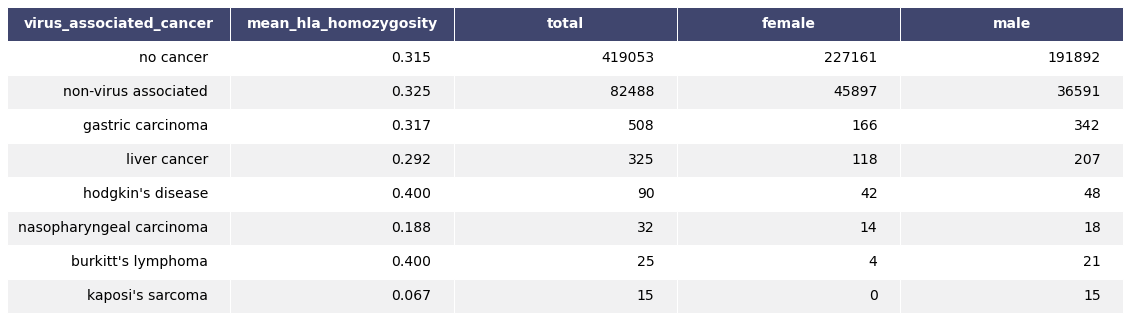

In [18]:
data = grouping_df.copy(deep=True)
data["mean_hla_homozygosity"] = data["mean_hla_homozygosity"].apply(lambda s: f"{s:.3f}")
fig, ax = render_mpl_table(data, header_columns=0, col_width=4.0)
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_summary_table.png")
grouping_df = grouping_df.loc[~ grouping_df["virus_associated_cancer"].isin(["no cancer", "non-virus associated"])]

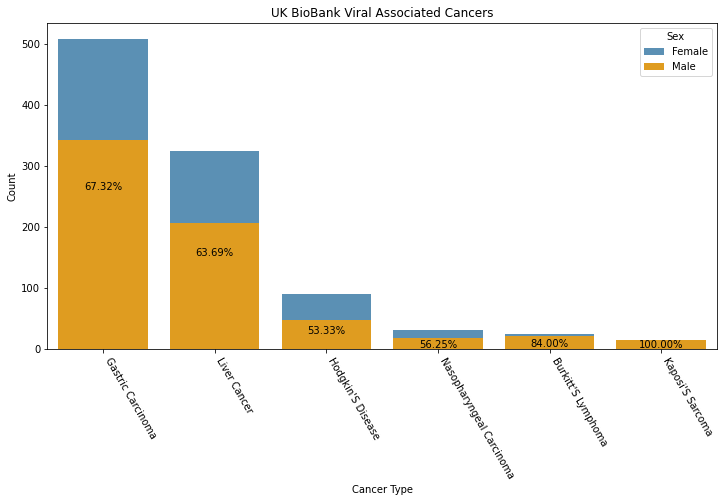

In [19]:
data = grouping_df
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=data, x="virus_associated_cancer", y="total", color="C0", alpha=.8, label="Female")
sns.barplot(data=data, x="virus_associated_cancer", y="male", color="orange", alpha=1, label="Male")

i = 0
for y_i, frac_male in zip(data["male"], data["male"] / data["total"]):
    ax.text(i, max(y_i * .8, 15), f"{frac_male * 100:.02f}%", ha="center", va="top")
    i += 1

add_plt_labels(ax=ax, x="Cancer Type", y="Count")
ax.legend(title="Sex")
ax.set_title("UK BioBank Viral Associated Cancers")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_summary.png")

# Viral Associated Age of Diagnosis Plots 

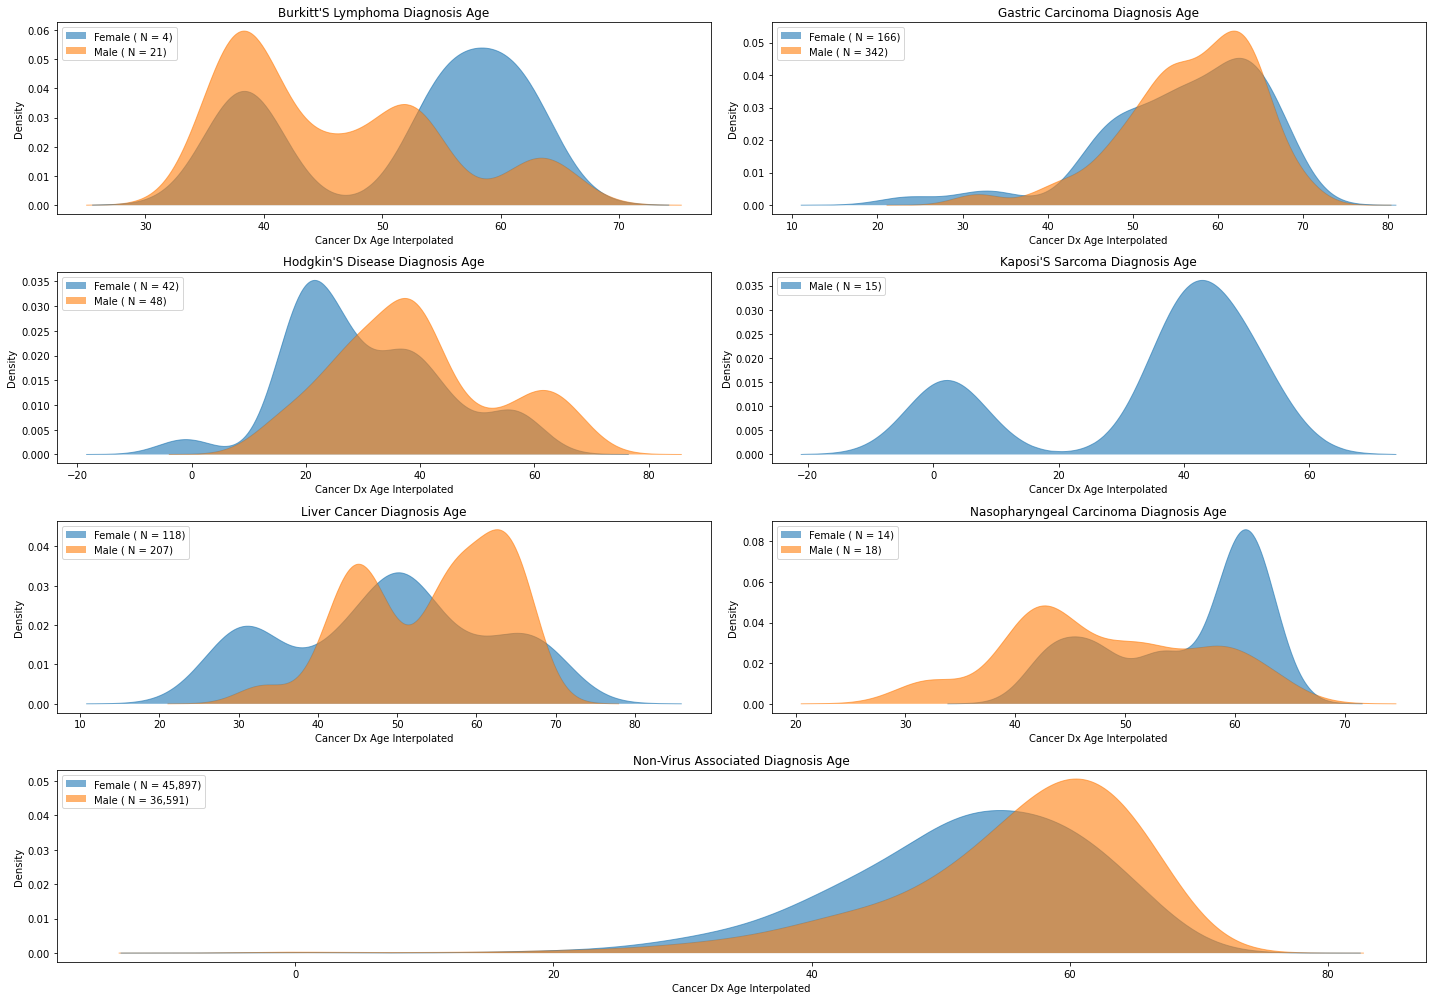

In [20]:
grouping = ICD10_data.groupby(["virus_associated_cancer"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "sex"

fig, axes = create_subplot(len(grouping), width=20, height_per=3)
for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_cancer"]), axes):
#     sns_wrapper(sns.kdeplot, data=subset, x=x, hue=hue, ax=ax, bw_method=.35, common_norm=False, shade=True)
    kde_plot(data=subset, x=x, hue=hue, ax=ax, bw=.35)

    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_type.title()} Diagnosis Age")
    ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_age_dx.png")

<AxesSubplot:xlabel='virus_associated_cancer', ylabel='cancer_dx_age_interpolated'>

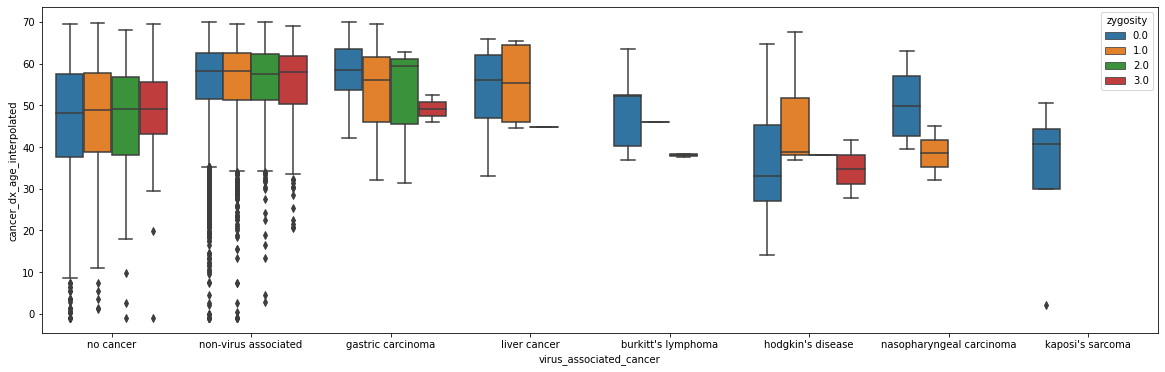

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=biobank_data.query("sex == 'Male'"), x="virus_associated_cancer", hue="zygosity", y=x, ax=ax)
# add_plt_labels(ax, x="Number of Homozygous HLA Alleles", y=x)

<ipython-input-21-9cd323754397>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


(-0.2, 8.4)

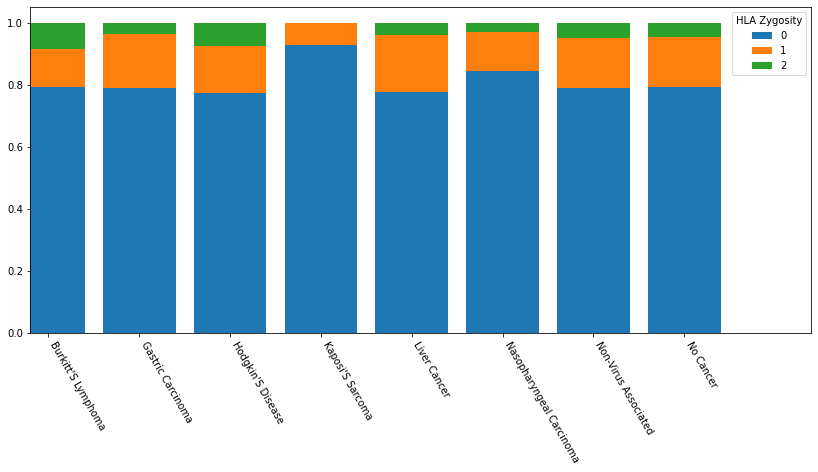

In [21]:
cancer_types = sorted(biobank_data["virus_associated_cancer"].unique())
cancer_types = [c for c in cancer_types if c != "no cancer"] + ["no cancer"]

values = []
for zygosity in range(3):
    data = biobank_data.query(f"zygosity == {zygosity}")
    values.append([(data["virus_associated_cancer"] == cancer_type).sum() for cancer_type in cancer_types])
values = np.cumsum(values, axis=0)
counts = values[-1]
values = values / counts

fig, ax = plt.subplots(figsize=(14, 6))
for i, value_set in zip(range(3), values):
    ax.bar(cancer_types, value_set, label=i, zorder=- i)

ax.legend(title="HLA Zygosity")
plt.draw()
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");
ax.set_xlim(-.2, len(counts) + .4)

Elapsed time: 1.0109 seconds


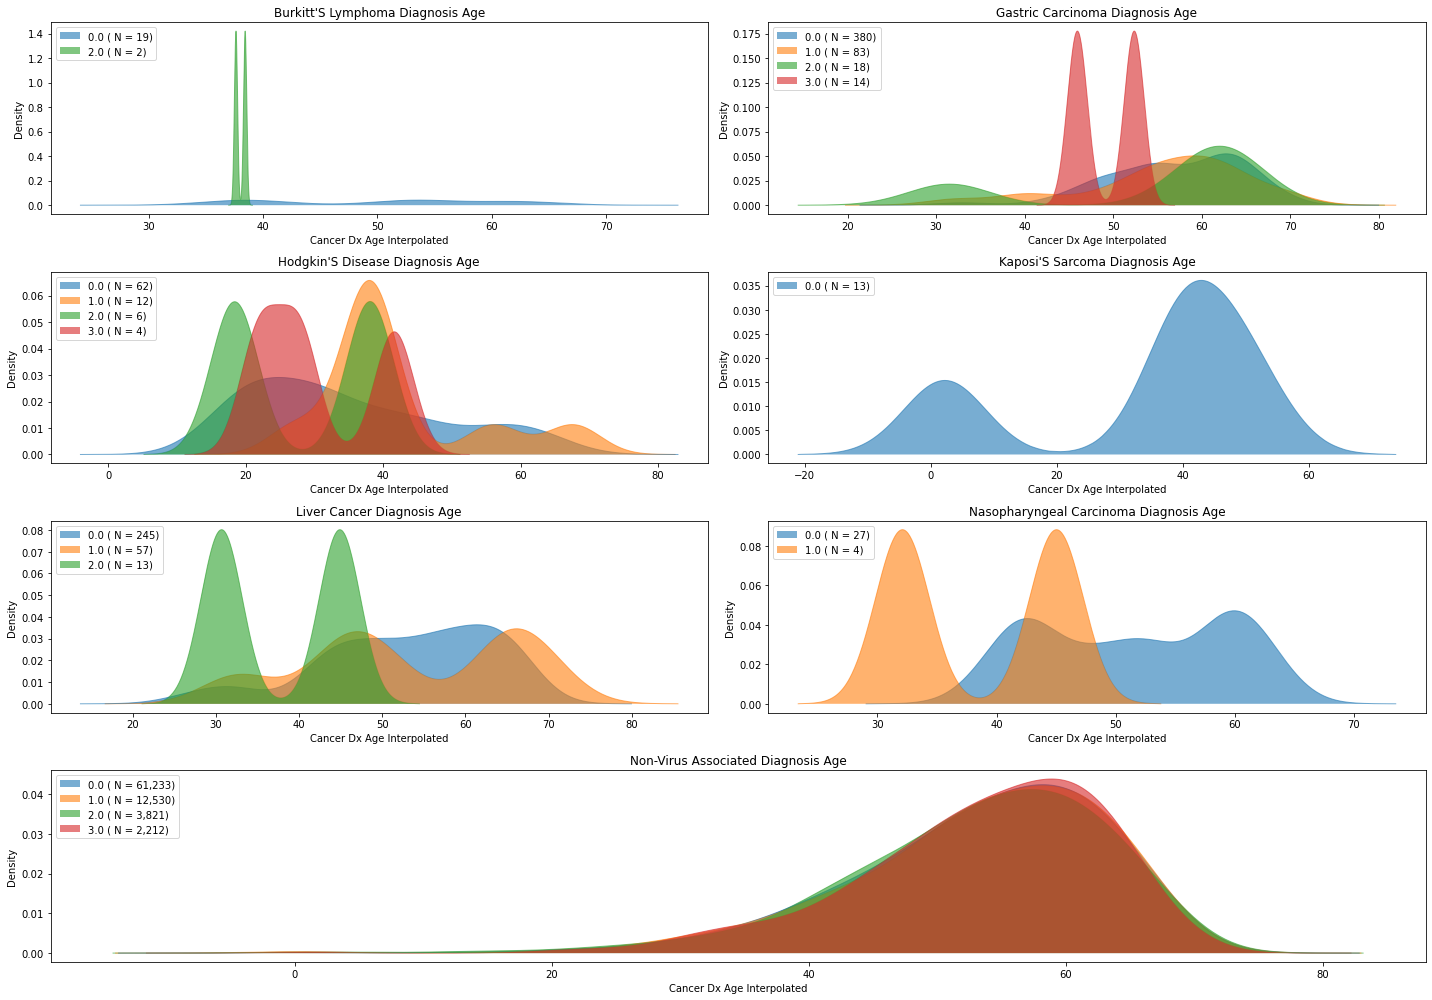

In [34]:
grouping = ICD10_data.query("sex == 'Male'").groupby(["virus_associated_cancer"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "zygosity"
with Timer() as t:
    fig, axes = create_subplot(len(grouping), width=20, height_per=3)
    for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_cancer"]), axes):
        kde_plot(data=subset, x=x, hue=hue, ax=ax, bw=.35)

        add_plt_labels(ax, x=x, y=y)
        ax.set_title(f"{str(cancer_type).title()} Diagnosis Age")
        ax.legend(loc="upper left")

    fig.tight_layout()
    fig.savefig("cancer_ICD10_plots/viral_associated_cancer_age_dx.png")

# Full ICD10 Analysis

In [ ]:
from analysis import *

In [ ]:
all_cancer_type_ICD10 = biobank_data[get_multiple_features_from_base_feature(biobank_data,
                                                                             "cancer_type_ICD10")].values.ravel()
all_cancers, counts = np.unique(all_cancer_type_ICD10[~pd.isnull(all_cancer_type_ICD10)], return_counts=True)
all_cancers, counts = all_cancers[counts > 10], counts[counts > 10]

for cancer, count in zip(all_cancers, counts):
    print(cancer, count)

In [22]:
cancer_dict = {}
cancer_values_list = []
cancer_list = ["other cancer"]
i = 1

for code, cancer in tqdm(constants.ICD10_CANCER_TYPES.items()):
    cancer_dict[cancer] = get_illness_value(biobank_data, [code], "cancer_type_ICD10")
    cancer_values_list.append(cancer_dict[cancer] * i)
    cancer_list.append(cancer)
    i += 1

  0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [93]:
df = biobank_data.loc[biobank_data["cancer_type_ICD10_1.0"].isna()]

In [95]:
df["n_cancers"].sum()

34976.0

In [83]:
ICD10_cancer_features = get_multiple_features_from_base_feature(biobank_data, "cancer_type_ICD10")

df = biobank_data
for feature in ICD10_cancer_features[:-2]:
    df = df.loc[~df[feature].isna()]

,cancer_type_ICD10,cancer_type_ICD10_1.0,cancer_type_ICD10_2.0,cancer_type_ICD10_3.0,cancer_type_ICD10_4.0,cancer_type_ICD10_5.0,cancer_type_ICD10_6.0,cancer_type_ICD10_7.0
11259,D41.2 Ureter,C44.4 Skin of scalp and neck,D07.5 Prostate,D41.1 Renal pelvis,D41.4 Bladder,D41.2 Ureter,NaN,NaN
12874,C44.4 Skin of scalp and neck,D04.4 Skin of scalp and neck,C83.3 Large cell (diffuse),C44.6 Skin of upper limb; including shoulder,C44.3 Skin of other and unspecified parts of face,C44.3 Skin of other and unspecified parts of face,NaN,NaN
31053,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,C67.9 Bladder; unspecified,D41.2 Ureter,C18.8 Overlapping lesion of colon,C68.0 Urethra,C44.7 Skin of lower limb; including hip,C20 Malignant neoplasm of rectum,NaN
63146,C54.1 Endometrium,C50.4 Upper-outer quadrant of breast,C54.1 Endometrium,C73 Malignant neoplasm of thyroid gland,C50.9 Breast; unspecified,C34.3 Lower lobe; bronchus or lung,NaN,NaN
63951,C43.5 Malignant melanoma of trunk,C44.3 Skin of other and unspecified parts of face,C44.5 Skin of trunk,D04.3 Skin of other and unspecified parts of face,D04.3 Skin of other and unspecified parts of face,D04.3 Skin of other and unspecified parts of face,NaN,NaN
71233,D05.7 Other carcinoma in situ of breast,D05.9 Carcinoma in situ of breast; unspecified,D05.7 Other carcinoma in situ of breast,C90.0 Multiple myeloma,C34.3 Lower lobe; bronchus or lung,C33 Malignant neoplasm of trachea,NaN,NaN
91863,C67.9 Bladder; unspecified,C66 Malignant neoplasm of ureter,D09.1 Other and unspecified urinary organs,C65 Malignant neoplasm of renal pelvis,C66 Malignant neoplasm of ureter,C65 Malignant neoplasm of renal pelvis,NaN,NaN
94921,C50.4 Upper-outer quadrant of breast,C44.3 Skin of other and unspecified parts of face,C44.5 Skin of trunk,C44.6 Skin of upper limb; including shoulder,C44.4 Skin of scalp and neck,C43.5 Malignant melanoma of trunk,C44.3 Skin of other and unspecified parts of face,NaN
102339,C18.7 Sigmoid colon,D09.1 Other and unspecified urinary organs,C67.5 Bladder neck,D41.2 Ureter,D41.2 Ureter,C34.1 Upper lobe; bronchus or lung,NaN,NaN
146356,C44.1 Skin of eyelid; including canthus,C44.4 Skin of scalp and neck,C34.1 Upper lobe; bronchus or lung,C61 Malignant neoplasm of prostate,D04.3 Skin of other and unspecified parts of face,C44.3 Skin of other and unspecified parts of face,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,NaN


In [75]:
no_cancer = pd.isnull(biobank_data["cancer_code"])
for feature in get_multiple_features_from_base_feature(biobank_data, "cancer_type_ICD10"):
    print(len(biobank_data) - biobank_data[feature].isna().sum())
    no_cancer = no_cancer & pd.isnull(biobank_data[feature])

no_cancer.sum()

83483
15379
3499
787
211
75
20
6


408381

In [84]:
biobank_data["cancer_code"].unique()

array([nan, 'malignant melanoma', 'breast cancer',
       'cin/pre-cancer cells cervix', 'thyroid cancer', 'ovarian cancer',
       'small intestine/small bowel cancer', 'basal cell carcinoma',
       'prostate cancer', 'colon cancer/sigmoid cancer',
       'large bowel cancer/colorectal cancer', 'cervical cancer',
       'uterine/endometrial cancer', 'non-melanoma skin cancer',
       'sarcoma/fibrosarcoma', 'squamous cell carcinoma',
       'hodgkins lymphoma / hodgkins disease', 'rodent ulcer',
       'bladder cancer', 'testicular cancer', 'non-hodgkins lymphoma',
       'rectal cancer', 'brain cancer / primary malignant brain tumour',
       'skin cancer', 'unclassifiable', 'kidney/renal cell cancer',
       'lymphoma', 'primary bone cancer', 'larynx/throat cancer',
       'small cell lung cancer', 'chronic lymphocytic', 'stomach cancer',
       'salivary gland cancer', 'eye and/or adnexal cancer',
       'other cancer of urinary tract', 'lung cancer', 'anal cancer',
       'liver/

In [ ]:
get_illness_value(biobank_data, [], "cancer_type_ICD10")`

In [62]:
np.sum(cancer_values_list, axis=0)

0

In [56]:
biobank_data["cancer_code"]

['other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer',
 'other cancer

['cancer_type_ICD10',
 'cancer_type_ICD10_1.0',
 'cancer_type_ICD10_2.0',
 'cancer_type_ICD10_3.0',
 'cancer_type_ICD10_4.0',
 'cancer_type_ICD10_5.0',
 'cancer_type_ICD10_6.0',
 'cancer_type_ICD10_7.0']